# Osteoarthritis Classification Using CNN

In [1]:
import zipfile
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pathlib
from collections import defaultdict

import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.python.client import device_lib

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1060166270376910400
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7348872773179471441
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available: 1


In [4]:
tf.config.set_visible_devices([], 'GPU')

## EDA

In [5]:
zip_ref= zipfile.ZipFile("Dataset 2B.zip", "r")
zip_ref.extractall()
zip_ref.close()

for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

for dirpath, dirnames, filenames in os.walk("test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 5 directories and 0 images in 'train'.
There are 0 directories and 1055 images in 'train\Doubtful'.
There are 0 directories and 1055 images in 'train\Mild'.
There are 0 directories and 1155 images in 'train\Moderate'.
There are 0 directories and 1055 images in 'train\Normal'.
There are 0 directories and 1055 images in 'train\Severe'.
There are 5 directories and 0 images in 'test'.
There are 0 directories and 117 images in 'test\Doubtful'.
There are 0 directories and 117 images in 'test\Mild'.
There are 0 directories and 117 images in 'test\Moderate'.
There are 0 directories and 118 images in 'test\Normal'.
There are 0 directories and 117 images in 'test\Severe'.


In [6]:
train_path= 'train'
test_path= 'test'
categories= ['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe']

image_data= []

def analyze_images(folder_path, dataset_type):
    for category in categories:
        category_path= os.path.join(folder_path, category)
        for img_name in os.listdir(category_path):
            img_path= os.path.join(category_path, img_name)
            img= cv2.imread(img_path)
            if img is not None:
                h, w, c= img.shape
                aspect_ratio= w / h
                image_data.append({
                    'dataset': dataset_type,
                    'category': category,
                    'width': w,
                    'height': h,
                    'channels': c,
                    'aspect_ratio': aspect_ratio,
                    'path': img_path
                })

analyze_images(train_path, 'train')
analyze_images(test_path, 'test')
df= pd.DataFrame(image_data)

In [7]:
print("\nDataset Distribution:")
print(df.groupby(['dataset', 'category']).size().unstack())


Dataset Distribution:
category  Doubtful  Mild  Moderate  Normal  Severe
dataset                                           
test           117   117       117     118     117
train         1055  1055      1155    1055    1055


### Distribution Category

In [8]:
train_counts= {
  'Doubtful': len(os.listdir('train/Doubtful')),
  'Mild': len(os.listdir('train/Mild')),
  'Moderate': len(os.listdir('train/Moderate')),
  'Normal': len(os.listdir('train/Normal')),
  'Severe': len(os.listdir('train/Severe'))
}

test_counts= {
  'Doubtful': len(os.listdir('test/Doubtful')),
  'Mild': len(os.listdir('test/Mild')),
  'Moderate': len(os.listdir('test/Moderate')),
  'Normal': len(os.listdir('test/Normal')),
  'Severe': len(os.listdir('test/Severe'))
}

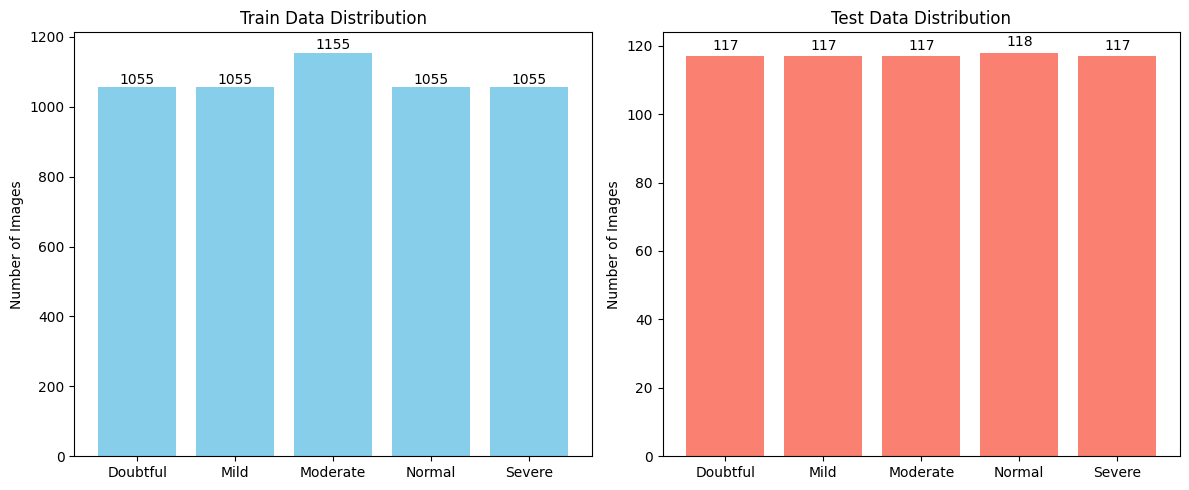

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars1 = plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Train Data Distribution')
plt.ylabel('Number of Images')

for bar in bars1:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')


plt.subplot(1, 2, 2)
bars2 = plt.bar(test_counts.keys(), test_counts.values(), color='salmon')
plt.title('Test Data Distribution')
plt.ylabel('Number of Images')

for bar in bars2:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


- The data distribution between the training and test sets is fairly balanced.


### Color Histogram per Category

Histogram untuk kelas: Doubtful


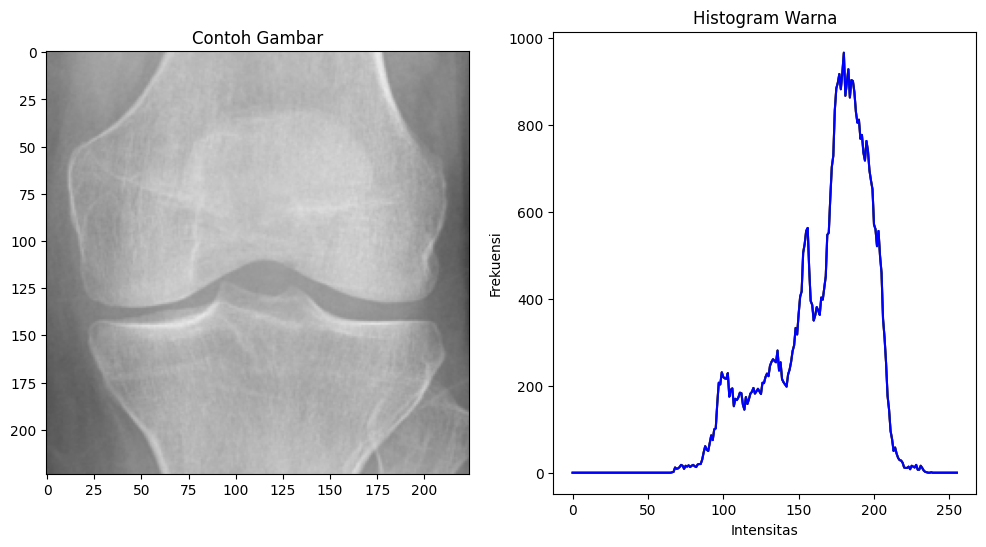

Histogram untuk kelas: Mild


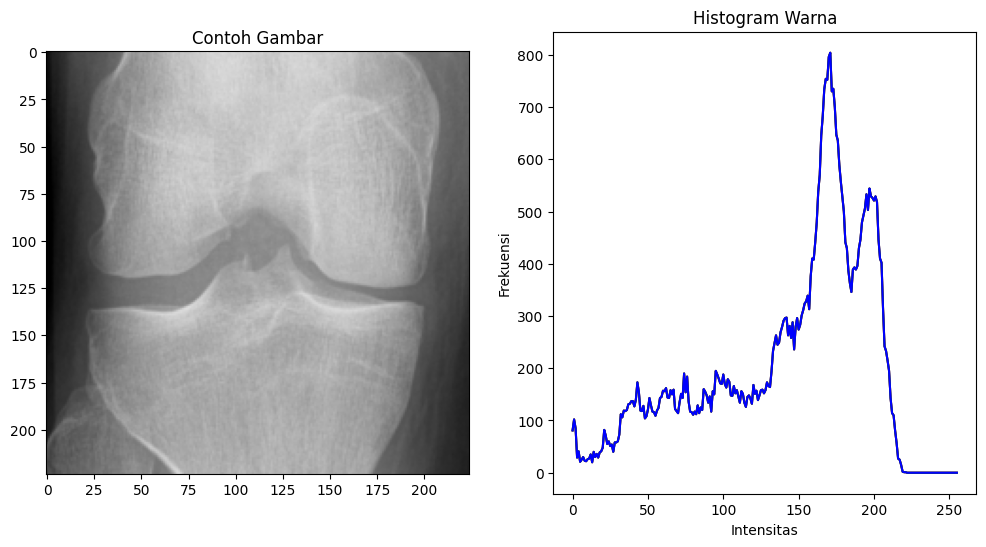

Histogram untuk kelas: Moderate


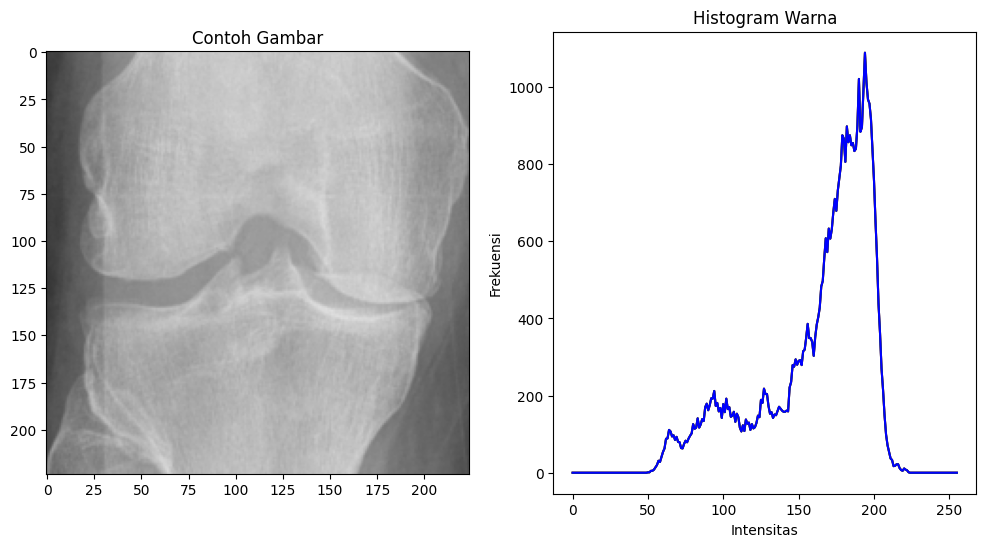

Histogram untuk kelas: Normal


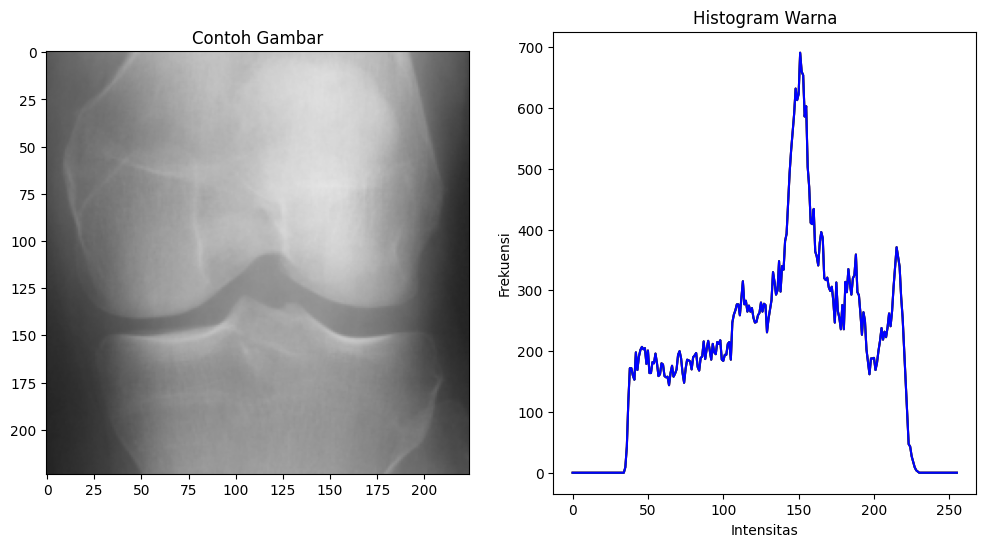

Histogram untuk kelas: Severe


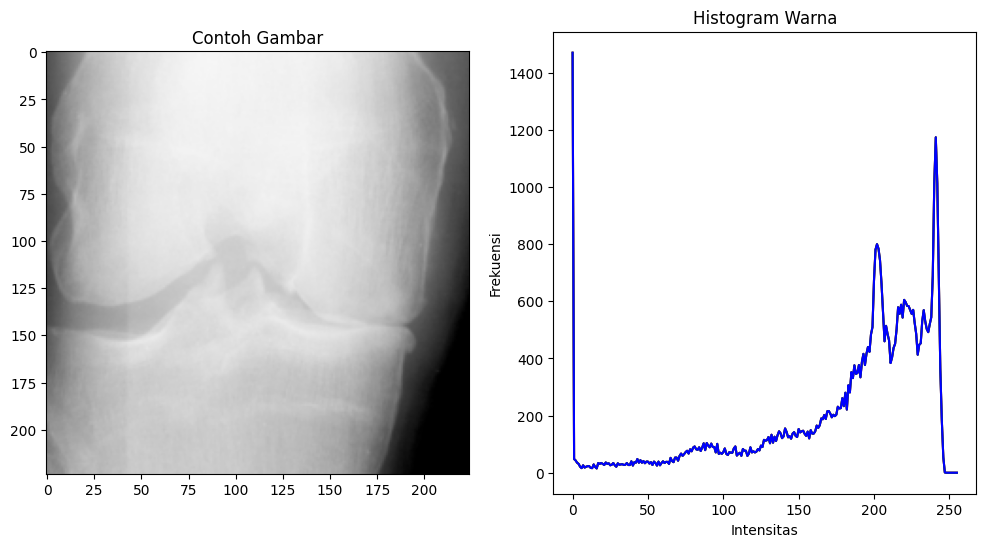

In [10]:
base_path= 'train'

data_dir= pathlib.Path("train")
classes= np.array(sorted([item.name for item in data_dir.glob('*')]))

def plot_color_histogram(image_path):
  img= cv2.imread(image_path)
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title('Contoh Gambar')

  plt.subplot(1, 2, 2)
  colors= ('r', 'g', 'b')
  for i, color in enumerate(colors):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color=color)
  plt.title('Histogram Warna')
  plt.xlabel('Intensitas')
  plt.ylabel('Frekuensi')
  plt.show()

for class_name in classes:
  img_path = os.path.join(base_path, class_name, os.listdir(os.path.join(base_path, class_name))[0])
  print(f"Histogram untuk kelas: {class_name}")
  plot_color_histogram(img_path)

- Visually, the image appears to be in grayscale; however, technically it is still in RGB format with the blue channel being more dominant.


### Aspect Ratio

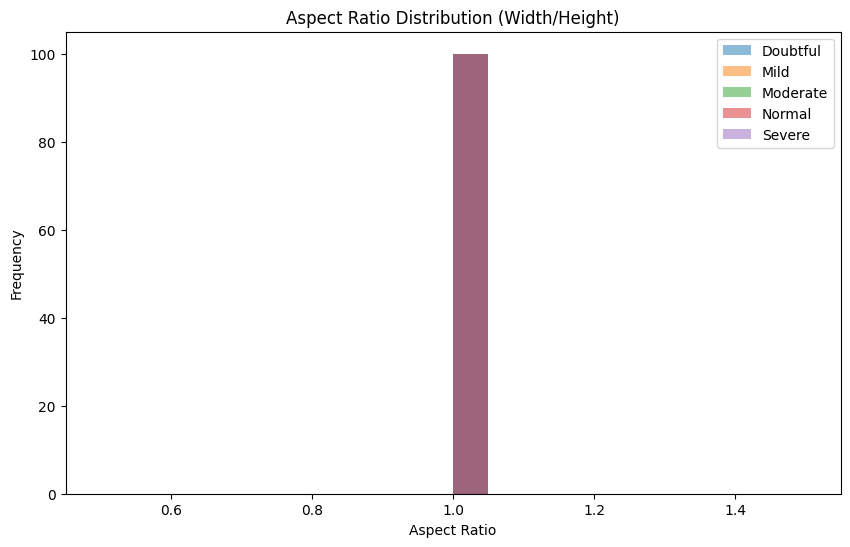

In [11]:
def plot_aspect_ratios():
  aspect_ratios = []
  categories_list = []
  
  for category in ['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe']:
    image_dir = f'train/{category}'
    for img_name in os.listdir(image_dir)[:100]:
      img_path = os.path.join(image_dir, img_name)
      img = cv2.imread(img_path)
      if img is not None:
        h, w = img.shape[:2]
        aspect_ratios.append(w / h)
        categories_list.append(category)
    
  plt.figure(figsize=(10, 6))
  for category in ['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe']:
    subset = [ar for ar, cat in zip(aspect_ratios, categories_list) if cat == category]
    plt.hist(subset, bins=20, alpha=0.5, label=category)
    
  plt.title('Aspect Ratio Distribution (Width/Height)')
  plt.xlabel('Aspect Ratio')
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

plot_aspect_ratios()

- All images have the same aspect ratio, with a value of 1.0, indicating that they are perfectly square in shape.


### Resolution

Total gambar yang dianalisis: 500
Lebar  - min: 224, max: 224, mean: 224.00
Tinggi - min: 224, max: 224, mean: 224.00

Beberapa resolusi unik (Width x Height):
224 x 224


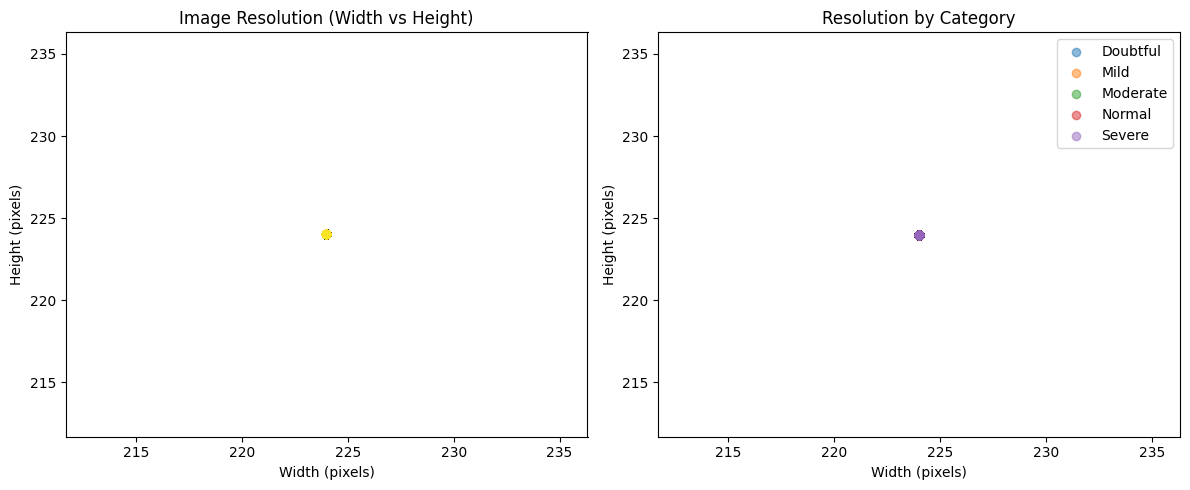

In [12]:
def plot_resolution_distribution():
  widths= []
  heights= []
  categories_list= []
    
  for category in ['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe']:
    image_dir = f'train/{category}'
    for img_name in os.listdir(image_dir)[:100]:
      img_path = os.path.join(image_dir, img_name)
      img = cv2.imread(img_path)
      if img is not None:
        h, w = img.shape[:2]
        widths.append(w)
        heights.append(h)
        categories_list.append(category)

  print(f"Total gambar yang dianalisis: {len(widths)}")
  print(f"Lebar  - min: {min(widths)}, max: {max(widths)}, mean: {np.mean(widths):.2f}")
  print(f"Tinggi - min: {min(heights)}, max: {max(heights)}, mean: {np.mean(heights):.2f}")

  unique_resolutions = list(set(zip(widths, heights)))
  print("\nBeberapa resolusi unik (Width x Height):")
  for res in unique_resolutions[:10]: 
    print(f"{res[0]} x {res[1]}")

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.scatter(widths, heights, alpha=0.3, c=[categories_list.index(cat) for cat in categories_list], cmap='viridis')
  plt.title('Image Resolution (Width vs Height)')
  plt.xlabel('Width (pixels)')
  plt.ylabel('Height (pixels)')
    
  plt.subplot(1, 2, 2)
  for category in ['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe']:
    subset_w = [w for w, cat in zip(widths, categories_list) if cat == category]
    subset_h = [h for h, cat in zip(heights, categories_list) if cat == category]
    plt.scatter(subset_w, subset_h, alpha=0.5, label=category)
  plt.legend()
  plt.title('Resolution by Category')
  plt.xlabel('Width (pixels)')
  plt.ylabel('Height (pixels)')
    
  plt.tight_layout()
  plt.show()
plot_resolution_distribution()

- All images have a resolution of 224 x 224 pixels.


### Variability (lighting, angle, and occlusions)

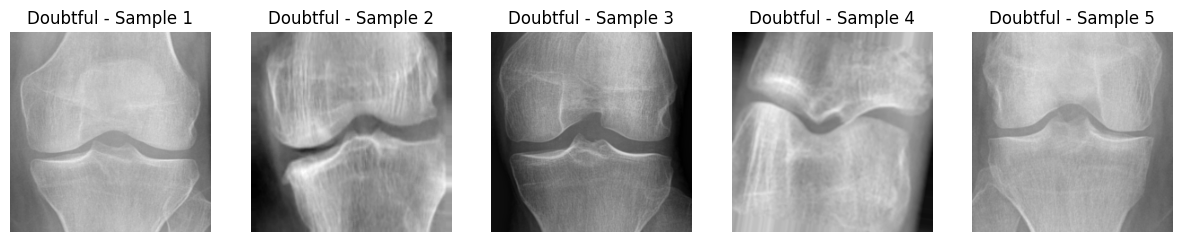

In [13]:
def plot_sample_variability(category, num_samples= 5):
  image_dir = f'train/{category}'
  sample_images = [os.path.join(image_dir, img) for img in os.listdir(image_dir)[:num_samples]]
    
  plt.figure(figsize=(15, 5))
  for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    if img is not None:
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.subplot(1, num_samples, i+1)
      plt.imshow(img_rgb)
      plt.title(f'{category} - Sample {i+1}')
      plt.axis('off')
  plt.show()

plot_sample_variability('Doubtful')

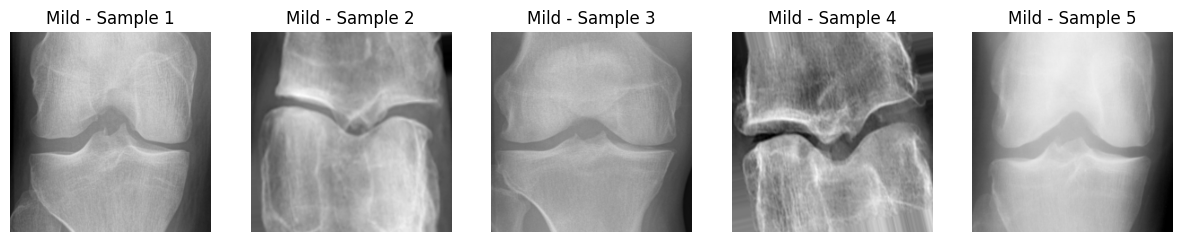

In [14]:
plot_sample_variability('Mild')

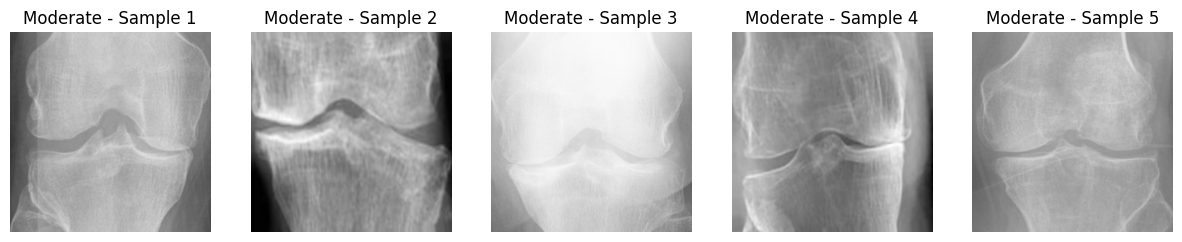

In [15]:
plot_sample_variability('Moderate')

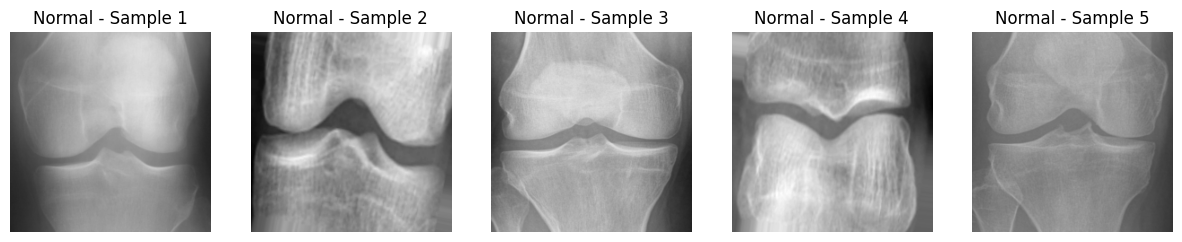

In [16]:
plot_sample_variability('Normal')

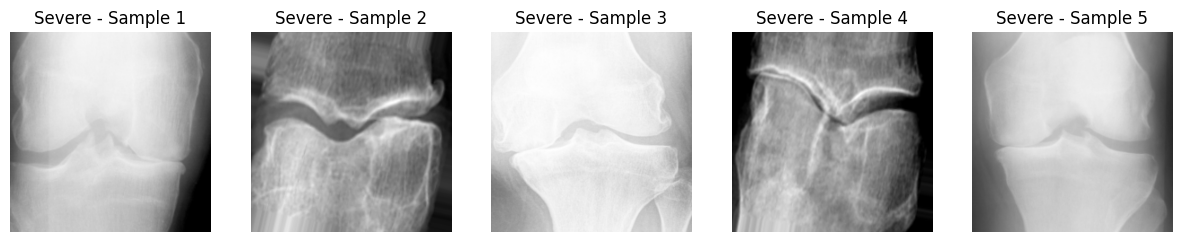

In [17]:
plot_sample_variability('Severe')

## Split Data

In [18]:
train_dir= "train"
test_dir= "test"
class_names= ['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe']

def count_images(directory):
  counts= {}
  for class_name in class_names:
    class_dir= os.path.join(directory, class_name)
    counts[class_name]= len(os.listdir(class_dir))
  return counts

initial_train_counts= count_images(train_dir)
initial_test_counts= count_images(test_dir)

print("Jumlah gambar awal:")
print("Train:", initial_train_counts)
print("Test:", initial_test_counts)
print()

Jumlah gambar awal:
Train: {'Doubtful': 1055, 'Mild': 1055, 'Moderate': 1155, 'Normal': 1055, 'Severe': 1055}
Test: {'Doubtful': 117, 'Mild': 117, 'Moderate': 117, 'Normal': 118, 'Severe': 117}



In [19]:
def split_train_validation_with_report(train_dir, validation_ratio=0.15):
  validation_dir= "validation"
  os.makedirs(validation_dir, exist_ok=True)
    
  counts_before= count_images(train_dir)
  counts_moved= defaultdict(int)
    
  for class_name in class_names:
    class_validation_dir= os.path.join(validation_dir, class_name)
    os.makedirs(class_validation_dir, exist_ok=True)
        
    src_dir= os.path.join(train_dir, class_name)
    files= os.listdir(src_dir)
    random.shuffle(files)
        
    num_validation= int(len(files) * validation_ratio)
    counts_moved[class_name] = num_validation
        
    for i in range(num_validation):
      src_path= os.path.join(src_dir, files[i])
      dst_path= os.path.join(class_validation_dir, files[i])
      shutil.move(src_path, dst_path)
    
  counts_after= count_images(train_dir)
  validation_counts= count_images(validation_dir)
    
  print("\nLaporan Splitting Data:")
  print(f"Total gambar yang dipindahkan ke validation: {sum(counts_moved.values())} ({validation_ratio*100}% dari train)")
  print("\nDetail per kelas:")
  for class_name in class_names:
    total_initial= counts_before[class_name]
    moved= counts_moved[class_name]
    remaining= counts_after[class_name]
    val_percentage= (moved / total_initial) * 100
        
    print(f"\nKelas {class_name}:")
    print(f"  Awal: {total_initial} gambar")
    print(f"  Dipindahkan ke validation: {moved} gambar ({val_percentage:.1f}%)")
    print(f"  Sisa di train: {remaining} gambar")
    print(f"  Validation: {validation_counts[class_name]} gambar")
    
  return validation_dir

validation_dir= split_train_validation_with_report(train_dir)


Laporan Splitting Data:
Total gambar yang dipindahkan ke validation: 805 (15.0% dari train)

Detail per kelas:

Kelas Doubtful:
  Awal: 1055 gambar
  Dipindahkan ke validation: 158 gambar (15.0%)
  Sisa di train: 897 gambar
  Validation: 296 gambar

Kelas Mild:
  Awal: 1055 gambar
  Dipindahkan ke validation: 158 gambar (15.0%)
  Sisa di train: 897 gambar
  Validation: 290 gambar

Kelas Moderate:
  Awal: 1155 gambar
  Dipindahkan ke validation: 173 gambar (15.0%)
  Sisa di train: 982 gambar
  Validation: 317 gambar

Kelas Normal:
  Awal: 1055 gambar
  Dipindahkan ke validation: 158 gambar (15.0%)
  Sisa di train: 897 gambar
  Validation: 290 gambar

Kelas Severe:
  Awal: 1055 gambar
  Dipindahkan ke validation: 158 gambar (15.0%)
  Sisa di train: 897 gambar
  Validation: 294 gambar


In [20]:
final_train_counts= count_images(train_dir)
final_validation_counts= count_images(validation_dir)
final_test_counts= count_images(test_dir)

In [21]:

total_images= (sum(final_train_counts.values()) + 
               sum(final_validation_counts.values()) + 
               sum(final_test_counts.values()))

print("\nDistribusi Akhir Data:")
print(f"Total semua gambar: {total_images}")
print(f"Train: {sum(final_train_counts.values())} gambar ({sum(final_train_counts.values())/total_images*100:.1f}%)")
print(f"Validation: {sum(final_validation_counts.values())} gambar ({sum(final_validation_counts.values())/total_images*100:.1f}%)")
print(f"Test: {sum(final_test_counts.values())} gambar ({sum(final_test_counts.values())/total_images*100:.1f}%)")

print("\nDetail Distribusi Akhir per Kelas:")
for class_name in class_names:
    print(f"\nKelas {class_name}:")
    print(f"  Train: {final_train_counts[class_name]} gambar")
    print(f"  Validation: {final_validation_counts[class_name]} gambar") 
    print(f"  Test: {final_test_counts[class_name]} gambar")
    print(f"  Total: {final_train_counts[class_name] + final_validation_counts[class_name] + final_test_counts[class_name]} gambar")


Distribusi Akhir Data:
Total semua gambar: 6643
Train: 4570 gambar (68.8%)
Validation: 1487 gambar (22.4%)
Test: 586 gambar (8.8%)

Detail Distribusi Akhir per Kelas:

Kelas Doubtful:
  Train: 897 gambar
  Validation: 296 gambar
  Test: 117 gambar
  Total: 1310 gambar

Kelas Mild:
  Train: 897 gambar
  Validation: 290 gambar
  Test: 117 gambar
  Total: 1304 gambar

Kelas Moderate:
  Train: 982 gambar
  Validation: 317 gambar
  Test: 117 gambar
  Total: 1416 gambar

Kelas Normal:
  Train: 897 gambar
  Validation: 290 gambar
  Test: 118 gambar
  Total: 1305 gambar

Kelas Severe:
  Train: 897 gambar
  Validation: 294 gambar
  Test: 117 gambar
  Total: 1308 gambar


## Preprocessing 

### Augmentation

In [22]:
train_datagen= ImageDataGenerator(
  rescale=1./255,
  rotation_range=5,
  shear_range=0.05,
  brightness_range=[0.8, 1.2],
  zoom_range=0.1,
  fill_mode='nearest'
)

validation_datagen= ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)

- The augmentation techniques used are not overly complex in order to preserve the essential characteristics of medical images and avoid distorting important information.  
- The main purpose of this augmentation is to enhance the model's generalization ability.


### Apply Augmentation

In [23]:
IMG_SIZE= (224, 224)
BATCH_SIZE= 32
train_dir= "train"
test_dir= "test"
validation_dir= "validation"

train_data= train_datagen.flow_from_directory(
  train_dir,
  target_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  class_mode='categorical',
  shuffle=True
)

valid_data= validation_datagen.flow_from_directory(
  validation_dir,
  target_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  class_mode='categorical',
  shuffle=False  
)

test_data= test_datagen.flow_from_directory(
  test_dir,
  target_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  class_mode='categorical',
  shuffle=False 
)

print("\nJumlah gambar setelah preprocessing:")
print(f"Train: {train_data.samples} gambar")
print(f"Validation: {valid_data.samples} gambar")
print(f"Test: {test_data.samples} gambar")

Found 4570 images belonging to 5 classes.
Found 1487 images belonging to 5 classes.
Found 586 images belonging to 5 classes.

Jumlah gambar setelah preprocessing:
Train: 4570 gambar
Validation: 1487 gambar
Test: 586 gambar


In [24]:
batch_images, batch_labels = next(train_data)
print(batch_images.shape)

(32, 224, 224, 3)


## CNN AlexNet Model

In [ ]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.MaxPooling2D((3, 3), strides=2),

  tf.keras.layers.ZeroPadding2D((2, 2)),
  tf.keras.layers.Conv2D(256, (5, 5), activation='relu'),
  tf.keras.layers.MaxPooling2D((3, 3), strides=2),

  tf.keras.layers.ZeroPadding2D((1, 1)),
  tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    
  tf.keras.layers.ZeroPadding2D((1, 1)),
  tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    
  tf.keras.layers.ZeroPadding2D((1, 1)),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((3, 3), strides=2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer= regularizers.l2(0.01)),
  tf.keras.layers.Dropout(0.5),
    
  tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer= regularizers.l2(0.01)),
  tf.keras.layers.Dropout(0.5),


  tf.keras.layers.Dense(5, activation='softmax')
])

In [32]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2d_27 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                        

In [34]:
history_1= model_1.fit(train_data,
                      epochs= 15,
                      steps_per_epoch= train_data.samples // train_data.batch_size,
                      validation_data= valid_data,
                      validation_steps= valid_data.samples // valid_data.batch_size)

Epoch 1/15
142/142 [==============================] - 113s 792ms/step - loss: 44.9919 - accuracy: 0.2025 - val_loss: 16.2226 - val_accuracy: 0.2154
Epoch 2/15
142/142 [==============================] - 113s 795ms/step - loss: 7.7162 - accuracy: 0.2129 - val_loss: 3.2022 - val_accuracy: 0.2154
Epoch 3/15
142/142 [==============================] - 113s 793ms/step - loss: 2.1960 - accuracy: 0.2151 - val_loss: 1.7256 - val_accuracy: 0.2154
Epoch 4/15
142/142 [==============================] - 294s 2s/step - loss: 1.6476 - accuracy: 0.2157 - val_loss: 1.6148 - val_accuracy: 0.2154
Epoch 5/15
142/142 [==============================] - 112s 788ms/step - loss: 1.6110 - accuracy: 0.2138 - val_loss: 1.6090 - val_accuracy: 0.2154
Epoch 6/15
142/142 [==============================] - 113s 795ms/step - loss: 1.6090 - accuracy: 0.2151 - val_loss: 1.6088 - val_accuracy: 0.2154
Epoch 7/15
142/142 [==============================] - 475s 3s/step - loss: 1.6089 - accuracy: 0.2151 - val_loss: 1.6087 - val

In [35]:
def plot_loss_curves(history):
  loss= history.history['loss']
  val_loss= history.history['val_loss']

  accuracy= history.history['accuracy']
  val_accuracy= history.history['val_accuracy']

  epochs= range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

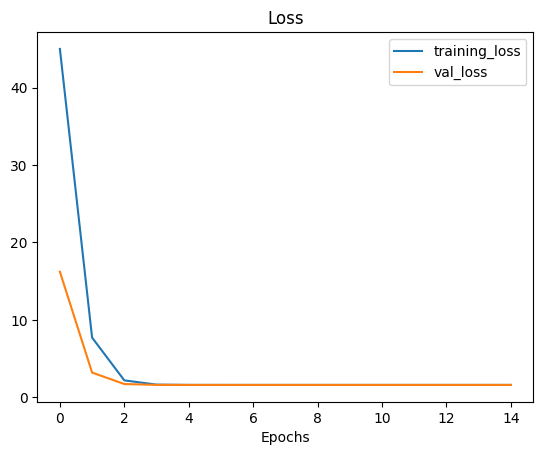

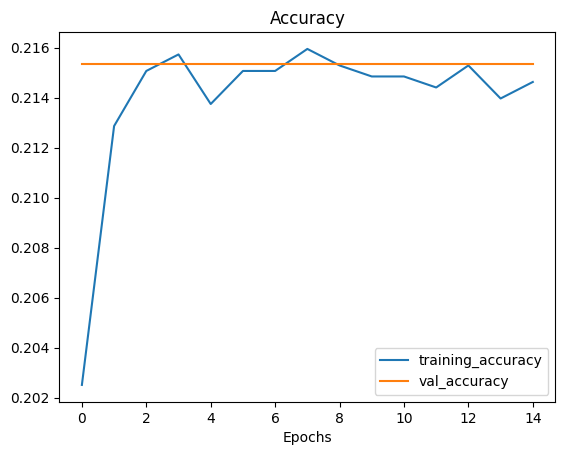

In [36]:
plot_loss_curves(history_1)

- The CNN model used is highly complex, with many convolutional and dense layers. However, the training results indicate overfitting, as both training and validation accuracy only reach around 21%.  
- The loss graph shows a sharp decline at the beginning but does not improve significantly after a few epochs, suggesting that the model is not learning effectively.  
- This is likely due to the model being too complex for a relatively limited dataset of only 4,570 training samples, making it difficult for the model to generalize well.


## Modified Model - EfficientNet

In [26]:
def mb_conv_block(x, filters, stride, expansion=4):
  channels= tf.keras.backend.int_shape(x)[-1]
    
  if expansion > 1:
    x= tf.keras.layers.Conv2D(channels * expansion, 1, padding='same')(x)
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.Activation('swish')(x)
    
  x= tf.keras.layers.DepthwiseConv2D(3, strides=stride, padding='same')(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x= tf.keras.layers.Activation('swish')(x)
    
  se= tf.keras.layers.GlobalAveragePooling2D()(x)
  se= tf.keras.layers.Dense(channels//4, activation='swish')(se)
  se= tf.keras.layers.Dense(channels * expansion, activation='sigmoid')(se)
  x= tf.keras.layers.Multiply()([x, se])
    
  x= tf.keras.layers.Conv2D(filters, 1, padding='same')(x)
  x= tf.keras.layers.BatchNormalization()(x)
    
  return x

inputs = tf.keras.Input(shape=(224, 224, 3))
x= tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
x= tf.keras.layers.BatchNormalization()(x)
x= tf.keras.layers.Activation('swish')(x)

x= mb_conv_block(x, filters=16, stride=1)
x= mb_conv_block(x, filters=24, stride=2)
x= mb_conv_block(x, filters=24, stride=1)
x= mb_conv_block(x, filters=40, stride=2)
x= mb_conv_block(x, filters=40, stride=1)
x= mb_conv_block(x, filters=80, stride=2)
x= mb_conv_block(x, filters=80, stride=1)
x= mb_conv_block(x, filters=112, stride=1)
x= mb_conv_block(x, filters=112, stride=1)
x= mb_conv_block(x, filters=192, stride=2)
x= mb_conv_block(x, filters=192, stride=1)
x= mb_conv_block(x, filters=320, stride=1)

x= tf.keras.layers.Conv2D(1280, 1, padding='same')(x)
x= tf.keras.layers.BatchNormalization()(x)
x= tf.keras.layers.Activation('swish')(x)
x= tf.keras.layers.GlobalAveragePooling2D()(x)
x= tf.keras.layers.Dropout(0.3)(x)
outputs= tf.keras.layers.Dense(5, activation='softmax')(x)

model_2= tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
def compile_and_train(model, name):
  model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy'])

  print(f"\nTraining {name}...")
  history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=15,
    validation_data=valid_data,
    validation_steps=len(valid_data)
  )
    
  return history

history_2= compile_and_train(model_2, "EfficientNet-style")


Training EfficientNet-style...
Epoch 1/15
143/143 [==============================] - 607s 4s/step - loss: 1.6342 - accuracy: 0.2372 - val_loss: 1.6090 - val_accuracy: 0.2132
Epoch 2/15
143/143 [==============================] - 575s 4s/step - loss: 1.6037 - accuracy: 0.2700 - val_loss: 1.6098 - val_accuracy: 0.2132
Epoch 3/15
143/143 [==============================] - 558s 4s/step - loss: 1.5671 - accuracy: 0.2985 - val_loss: 1.6129 - val_accuracy: 0.1991
Epoch 4/15
143/143 [==============================] - 541s 4s/step - loss: 1.5434 - accuracy: 0.3026 - val_loss: 1.6139 - val_accuracy: 0.2132
Epoch 5/15
143/143 [==============================] - 529s 4s/step - loss: 1.4789 - accuracy: 0.3354 - val_loss: 1.5698 - val_accuracy: 0.2542
Epoch 6/15
143/143 [==============================] - 536s 4s/step - loss: 1.4197 - accuracy: 0.3462 - val_loss: 1.6930 - val_accuracy: 0.3349
Epoch 7/15
143/143 [==============================] - 730s 5s/step - loss: 1.3426 - accuracy: 0.3906 - val_los

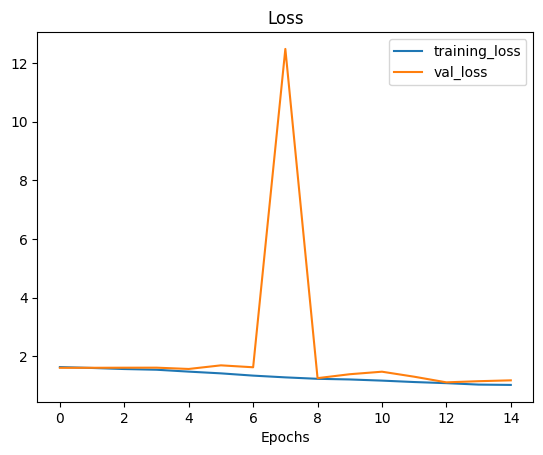

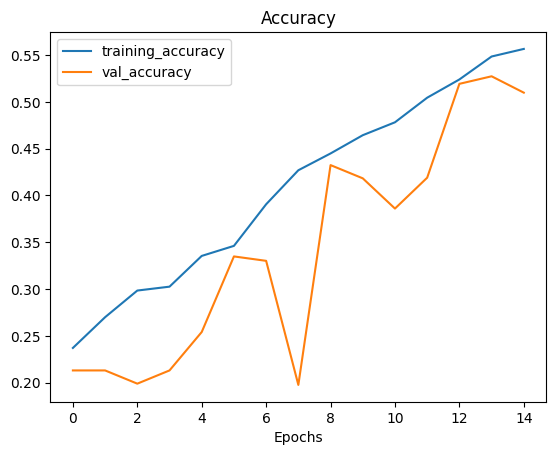

In [30]:
plot_loss_curves(history_2)

- This modified model shows a significant improvement compared to the initial model, as seen by the validation accuracy increasing from 21% to over 50%.  
- Although there was a sharp spike in validation loss at epoch 7, the model's performance eventually stabilized and continued to improve.  
- This indicates that the MBConv architecture — incorporating **Swish activation**, **SE blocks**, and **depthwise convolution** — successfully enhanced the model’s feature extraction capabilities in this case.


## Evaluation Model

### Model CNN AlexNet Evaluation

In [37]:
test_loss, test_acc= model_1.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

y_pred= model_1.predict(test_data).argmax(axis=1)  
y_true= test_data.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

19/19 [==============================] - 3s 136ms/step - loss: 1.6101 - accuracy: 0.1997
Test Accuracy: 0.19965870678424835
Test Loss: 1.6101018190383911
19/19 [==============================] - 3s 128ms/step

Classification Report:
              precision    recall  f1-score   support

    Doubtful       0.00      0.00      0.00       117
        Mild       0.00      0.00      0.00       117
    Moderate       0.20      1.00      0.33       117
      Normal       0.00      0.00      0.00       118
      Severe       0.00      0.00      0.00       117

    accuracy                           0.20       586
   macro avg       0.04      0.20      0.07       586
weighted avg       0.04      0.20      0.07       586



c:\Users\Kelvin Jonathan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kelvin Jonathan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kelvin Jonathan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

- The AlexNet CNN model shows very poor performance, with an accuracy of only **0.20**, meaning that only 20% of the predictions on the test data were correct. This indicates that the model is far from effective in correctly identifying all classes.

- **Precision** is low across all classes (mostly 0.00), indicating that when the model predicts a certain class, it is usually incorrect. For example, in the "Moderate" class, the precision is only **0.20**, meaning only 20% of the predicted "Moderate" labels are actually correct.

- **Recall** is high only for the "Moderate" class (**1.00**), while all other classes have a recall of **0.00**. This shows that the model focuses exclusively on one class and completely ignores the others — a problem known as **class imbalance in prediction**, even though the actual data distribution is balanced.

- Overall, the model is unable to distinguish between classes and tends to predict only one class. This could be caused by **overfitting due to an overly complex model** or **insufficient training data**.


### Modified Model Evaluation

In [ ]:
test_loss, test_acc= model_2.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

y_pred= model_2.predict(test_data).argmax(axis=1)  
y_true= test_data.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

19/19 [==============================] - 11s 578ms/step - loss: 1.2884 - accuracy: 0.4471
Test Accuracy: 0.447098970413208
Test Loss: 1.2884193658828735
19/19 [==============================] - 12s 570ms/step

Classification Report:
              precision    recall  f1-score   support

    Doubtful       0.38      0.29      0.33       117
        Mild       0.31      0.50      0.38       117
    Moderate       0.41      0.55      0.47       117
      Normal       0.49      0.17      0.25       118
      Severe       0.78      0.74      0.76       117

    accuracy                           0.45       586
   macro avg       0.47      0.45      0.44       586
weighted avg       0.47      0.45      0.44       586



- Architectural modifications such as the addition of **depthwise convolution**, **SE blocks**, and **swish activation** have successfully improved the model’s generalization. This is evident from the increased accuracy, precision, and recall across almost all classes. The model is now more balanced and accurate in classification compared to the initial AlexNet-based version.

- The **AlexNet** model only achieved an accuracy of **0.20**, indicating that it frequently misclassified images. After being modified into an **EfficientNet-based model**, the accuracy improved to **0.45**, demonstrating a much better overall prediction capability.

- In **AlexNet**, precision was extremely low, with most classes having a value of **0.00**, meaning the model’s "correct" predictions were mostly incorrect. The modified EfficientNet model showed a significant improvement, particularly for the **Severe** class, which reached a precision of **0.78**.

- The initial model’s **recall** was poor, recognizing only the **Moderate** class correctly while ignoring the others. After modification, all classes are now detected, with both **Moderate** and **Severe** classes achieving recall scores above **0.5**.

- The **F1 score** in the AlexNet model was very low, indicating an imbalance between precision and recall. In contrast, the modified model improved this significantly, with an average F1 score rising to approximately **0.44**, indicating more stable and balanced performance.
